<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/image_classification/mlp_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train an MLP to classify handwritten digits using MNIST dataset. The MNIST dataset is a set of 60,000 training
images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. This is considered as the "Hello World" of deep learning.

The process will be broken down into the following steps:

1. Load and visualize the dataset
2. Define a neural network
3. Define a Loss function and optimizer
4. Train the model on the training dataset
5. Evaluate the performance of the trained model on the test dataset


In [1]:
# import required libraries
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda in available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available


### Load and visualize the dataset

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# obtain training indices for creating a validation dataset
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# choose percentage of training data for validation
valid_size = 0.2
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare train, test and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify image classes in the dataset
classes = ['0','1','2','3','4','5', '6','7','8','9']

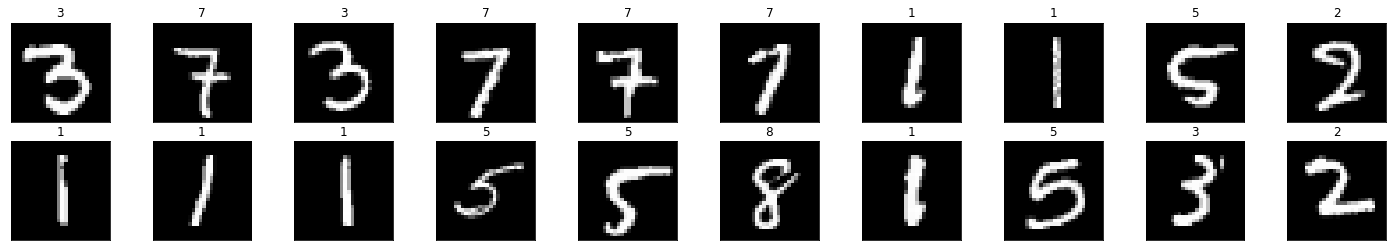

In [4]:
# visualize a batch of training data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Define a neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512) 
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x
  
model = Net()
model.to(device)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
from torchsummary import summary

# display model
summary(model, input_size=(batch_size, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


## Define a Loss function and optimizer

In [7]:
# specify loss (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Train the model on the training dataset

In [8]:
# number of epochs to train the model
num_epochs = 10

# track training and validation losses
train_loss, valid_loss = [], []

# initialize trackers for min validation loss
min_valid_loss = np.inf

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_valid_loss = 0.0

  #--------- train the model -----------
  model.train()

  for batch_idx, data in enumerate(train_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # backward loss
    loss.backward()
    # update parameters
    optimizer.step()
    # update training loss
    running_train_loss += loss.item() 

  # -------- validate the model ---------
  # prefer model for evaluation
  model.eval()

  for batch_idx, data in enumerate(valid_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # forward pass
    outputs = model(inputs)
    # calculate the batch loss
    loss = criterion(outputs, targets)
    # update validation loss
    running_valid_loss += loss.item()

  
  # calculate average losses over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  running_valid_loss = running_valid_loss / len(valid_loader)

  train_loss.append(running_train_loss)
  valid_loss.append(running_valid_loss)

  print("Epochs: {} \tTraining loss: {:.6f} \tValidation loss: {:.6f}".format(epoch+1, running_train_loss, running_valid_loss))

  # save model if validation loss has decreased
  if running_valid_loss <= min_valid_loss:
    print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ... ".format(
        min_valid_loss, running_valid_loss
    ))

    torch.save(model.state_dict(), 'model.pt')
    min_valid_loss = running_valid_loss

print("Finished training!")

Epochs: 1 	Training loss: 0.950251 	Validation loss: 0.378800
Validation loss decreased (inf --> 0.378800). Saving model ... 
Epochs: 2 	Training loss: 0.354383 	Validation loss: 0.289304
Validation loss decreased (0.378800 --> 0.289304). Saving model ... 
Epochs: 3 	Training loss: 0.283571 	Validation loss: 0.234667
Validation loss decreased (0.289304 --> 0.234667). Saving model ... 
Epochs: 4 	Training loss: 0.233531 	Validation loss: 0.200406
Validation loss decreased (0.234667 --> 0.200406). Saving model ... 
Epochs: 5 	Training loss: 0.199166 	Validation loss: 0.173921
Validation loss decreased (0.200406 --> 0.173921). Saving model ... 
Epochs: 6 	Training loss: 0.172304 	Validation loss: 0.154744
Validation loss decreased (0.173921 --> 0.154744). Saving model ... 
Epochs: 7 	Training loss: 0.152805 	Validation loss: 0.137947
Validation loss decreased (0.154744 --> 0.137947). Saving model ... 
Epochs: 8 	Training loss: 0.137420 	Validation loss: 0.128188
Validation loss decreased 

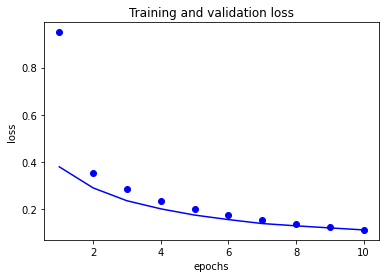

In [9]:
# plot training and validation losses for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'b', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()

### Evaluate the performance of the trained model on the test dataset

In [10]:
# load model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [11]:
# track test loss and accuracy
test_loss = 0.0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

# prepare model for evaluation
model.eval()

for batch_idx, data in enumerate(test_loader):
  inputs, targets = data
  inputs, targets = inputs.to(device), targets.to(device)
  
  # forward pass
  outputs = model(inputs)
  # calculate the batch loss
  loss = criterion(outputs, targets)
  # update test loss
  test_loss += loss.item()
  # convert output probabilities to predicted class
  _, predictions = torch.max(outputs, 1)
  # compare predictions to true labels
  correct_tensor = predictions.eq(targets.data.view_as(predictions))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each class
  for i in range(batch_size):
    label = targets.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print("Test loss (overall): {:6f}\n".format(test_loss))

# print test accuracy for each classes
for i in range(len(classes)):
  if class_total[i] > 0:
    accuracy = (100 * class_correct[i]) / class_total[i]
    print(f'Test accuracy of {classes[i]:10s}: {accuracy:.1f} % ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')

# overall test accuracy
test_acc = 100 * np.sum(class_correct) / np.sum(class_total)
print("\nTest accuracy (overall): %2d%% (%2d/%2d)" % ( 
      test_acc, np.sum(class_correct), np.sum(class_total)))

Test loss (overall): 0.005150

Test accuracy of 0         : 98.8 % (968/980)
Test accuracy of 1         : 99.0 % (1124/1135)
Test accuracy of 2         : 96.7 % (998/1032)
Test accuracy of 3         : 96.5 % (975/1010)
Test accuracy of 4         : 97.4 % (956/982)
Test accuracy of 5         : 94.8 % (846/892)
Test accuracy of 6         : 97.3 % (932/958)
Test accuracy of 7         : 96.7 % (994/1028)
Test accuracy of 8         : 95.0 % (925/974)
Test accuracy of 9         : 94.4 % (953/1009)

Test accuracy (overall): 96% (9671/10000)
